In [1]:
from bs4 import BeautifulSoup
import requests
import re
import json
from transformers import pipeline
import pandas as pd
import torch
import os
from tqdm.notebook import tqdm
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import torch_geometric
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
from matplotlib import animation
from torch_geometric.utils import to_networkx
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer 
nltk.download('popular')
from nltk.tokenize import wordpunct_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |   

In [2]:
def get_links_from_html_soup(html_soup):
    p_tags = html_soup.find('div', {'id': 'mw-content-text'}).find('div', class_='mw-content-ltr mw-parser-output').findAll(
        'p')

    links = []
    for p_tag in p_tags:
        for a_tag in p_tag.findAll('a'):
            link = a_tag.get('href')
            if link and re.match(r'/wiki/', link):
                link = 'https://ru.wikipedia.org' + link
                links.append(link)

    return links

In [3]:
def get_html_soup_from_link(link):
    while True:
        response = requests.get(link)
        if response.status_code == 200:
            break
        else:
            print(f'unsuccesfull request at - ', link, ' with code = ', response.status_code)
            break
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [4]:
def recursive_parse(start_link, cur_depth, max_depth, link_map, exceed=False):
    if cur_depth >= max_depth:
        return link_map

    html_soup = get_html_soup_from_link(start_link)
    links = get_links_from_html_soup(html_soup)
    
    if link_map.get(start_link):
        link_map[start_link].extend(links)
    else:
        link_map[start_link] = links

    link_map[start_link] = list(set(link_map[start_link]))

    if exceed and len(list(link_map.keys())) > exceed:
        return link_map

    for link in links:
        recursive_parse(link, cur_depth+1, max_depth, link_map, exceed)
        
    return link_map

In [5]:
if os.path.isfile('links.json'):
    with open('links.json') as file:
        link_map = json.load(file)
else:    
    link_map = {}
    link_map = recursive_parse('https://ru.wikipedia.org/wiki/%D0%92%D0%B8%D0%B4%D0%B5%D0%BE%D0%B8%D0%B3%D1%80%D0%B0', 0, 3, link_map)
    with open('links.json', 'w') as file:
        json.dump(link_map, file)

In [6]:
all_links = []
for val in list(link_map.values()):
    all_links.extend(val)
for key in list(link_map.keys()):
    all_links.append(key)
all_links = list(set(all_links))
print(len(all_links))

30257


# Получение текста и заголовков

In [7]:
def create_wiki_df(links, stop):
    df = pd.DataFrame(columns = ['link', 'header', 'text', 'category'])
    i = 0
    for link in links:
        try:
            soup = get_html_soup_from_link(link)
            paras = []
            for p in soup.findAll('p'):
                paras.append(str(p.text))
            heads = []
            for h in soup.findAll('span', attrs={'mw-headline'}):
                heads.append(str(h.text))
            text = [val for pair in zip(paras, heads) for val in pair]
            text = ' '.join(text)
            
            text = re.sub(r"\[.*?\]+", '', text)
            text = text.replace('\n', '')[:-11]
            text = text.replace(u'\xad', '')
            text = text.replace(u'\xa0', ' ')
    
            header = soup.find('span', class_='mw-page-title-main')
            if header:
                header = header.text
            elif soup.find('h1', attrs = {'id': 'firstHeading', 'class': 'firstHeading mw-first-heading'}).find('i'):
                header = soup.find('h1', attrs = {'id': 'firstHeading', 'class': 'firstHeading mw-first-heading'}).find('i').text
            else:
                header = soup.find('h1', attrs = {'id': 'firstHeading', 'class': 'firstHeading mw-first-heading'}).text

            cat = soup.find('div', {'id': 'mw-normal-catlinks'}).find('ul').find('li').text
    
            df.loc[len(df)] = [link, header, text, cat]
            i+=1
            print(f'done {round(max(i/stop, i/len(links))*100, 2)}%')
            if i == stop:
                break
        except Exception as e:
            print('error at ', link)
            print(e)
    return df

In [8]:
if os.path.isfile('wiki.csv'):
    df = pd.read_csv('wiki.csv', index_col='Unnamed: 0')
else:    
    df = create_wiki_df(all_links, 20000)
    df.to_csv('wiki.csv')
df.dropna(inplace=True)
df.drop_duplicates(subset=['header'], inplace=True)
df = df.loc[df['category'].isin(df['category'].value_counts()[:10].index.to_list())]
df.head(2)

,link,header,text,category
1,https://ru.wikipedia.org/wiki/G7_Teams,G7 Teams,"G7 Teams — международная федерация, созданная ...",Компании по алфавиту
19,https://ru.wikipedia.org/wiki/Atari_Games,Atari Games,Warner Communications (1984–1985) История Namc...,Компании по алфавиту


# Обработка текста

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        return self.df.iloc[item]['text']

In [10]:
def summarize(df):
    col = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = Dataset(df)
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    summarizer = pipeline('summarization', model='IlyaGusev/rut5_base_headline_gen_telegram', device=device)
    for out in tqdm(summarizer(dataset, max_length=50, batch_size=1), total=len(dataset)):
        try:
            for item in out:
                col.append(item['summary_text'])
        except Exception:
            print('error')
            for _ in range(6):
                col.append('None')
            torch.cuda.empty_cache()

    df['summary'] = col
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    return df

In [11]:
if os.path.isfile('wiki_sum.csv'):
    print('opening wiki_sum.csv')
    df = pd.read_csv('wiki_sum.csv', index_col='Unnamed: 0')
else:
    print('creating wiki_sum.csv')
    df = summarize(df)
    df.to_csv('wiki_sum.csv')
df.dropna(inplace=True)
df.head(2)

opening wiki_sum.csv


,link,header,text,category,summary
1,https://ru.wikipedia.org/wiki/G7_Teams,G7 Teams,"G7 Teams — международная федерация, созданная ...",Компании по алфавиту,"G7 Teams — международная федерация, созданная ..."
19,https://ru.wikipedia.org/wiki/Atari_Games,Atari Games,Warner Communications (1984–1985) История Namc...,Компании по алфавиту,"История Namco, Namco, Time Warner Interactive ..."


# Создание базы знаний

In [12]:
G = nx.DiGraph()

In [13]:
def create_nodes(df):
    nodes = []
    for i in range(len(df)):
        nodes.append((df.iloc[i]['header'], {'summary': df.iloc[i]['summary'], 'link': df.iloc[i]['link'], 'text': df.iloc[i]['text'], 'category': df.iloc[i]['category']}))
    return nodes

In [14]:
def create_edges(link_map, df):
    edges = []
    existing_links = df['link'].to_list()
    for key in list(link_map.keys()):
        if key not in existing_links:
            continue
        for val in link_map.get(key):
            if val not in existing_links:
                continue
            edges.append((df.loc[df['link'] == key]['header'].iloc[0], df.loc[df['link'] == val]['header'].iloc[0]))
    return edges

In [15]:
G.add_nodes_from(create_nodes(df))
G.add_edges_from(create_edges(link_map, df))

In [16]:
def create_name_to_long_dict(nodes):
    return {nodes[i]: i for i in range(len(nodes))}

In [17]:
def create_edge_index(nodes_dict, edges):
    edge_index = [[], []]
    for connection in edges:
        edge_index[0].append(nodes_dict[connection[0]])
        edge_index[1].append(nodes_dict[connection[1]])
    return edge_index

In [18]:
def create_y_data(G):
    return [node[1]['category'] for node in G.nodes(data=True)]

In [19]:
def create_x_data(G):
    return [node[1]['summary'] for node in G.nodes(data=True)]

In [20]:
def to_categorical(y):
    y_dict = {}
    i = 0
    for cat in y:
        if cat not in y_dict.keys():
            y_dict[cat] = i
            i+=1
    y_new = []
    for cat in y:
        y_new.append(y_dict[cat])
    return y_new, y_dict

In [21]:
def to_idx(x):
    vocab = {'<UNK>': 0, '<PAD>': 1}
    x_new = []
    i = len(vocab)
    max_len = 0
    for sent in x:
        if len(wordpunct_tokenize(sent)) > max_len:
            max_len = len(wordpunct_tokenize(sent))
        for token in wordpunct_tokenize(sent):
            if not vocab.get(token):
                vocab[token] = i
                i += 1
    for sent in x:
        x_new.append([])
        for i, token in enumerate(wordpunct_tokenize(sent), start=1):
            x_new[-1].append(vocab.get(token, 0))
        for _ in range(max_len-i):
            x_new[-1].append(1)
    x_new2 = torch.FloatTensor()
    x_new2 = x_new2.new_empty(size=(len(x_new), max_len))
    for i in range(len(x_new)):
        x_new2[i] = torch.FloatTensor(x_new[i])
    return x_new2, vocab

In [22]:
def create_data_obj(G):
    nodes_dict = create_name_to_long_dict(list(G.nodes))
    edge_index = torch.LongTensor(create_edge_index(nodes_dict, list(G.edges)))
    y, y_vocab = to_categorical(create_y_data(G))
    y = torch.LongTensor(y)
    x, x_vocab = to_idx(create_x_data(G))
    data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y)
    return data, x_vocab, y_vocab

In [23]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 2 * num_features, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * num_features, num_features, cached=True) # cached only for transductive learning
        self.fc = torch.nn.Linear(num_features, num_classes)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

In [24]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [25]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=20):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = 1000

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      print(f'\ncounter = {self.counter}')
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

In [26]:
def train_one_epoch_gcc(model, optimizer, loss_func, x, y, train_pos_edge_index):
    model.train()
    optimizer.zero_grad()
    y_pred = model.forward(x, train_pos_edge_index)
    loss = loss_func.forward(y_pred, y)
    loss.backward()
    optimizer.step()
    _, y_pred = torch.max(y_pred, 1)
    return loss.item(), accuracy(y_pred, y)

def val_one_epoch_gcc(model, loss_func, x, y, val_pos_edge_index):
    model.eval()
    y_pred = model.forward(x, val_pos_edge_index)
    loss = loss_func.forward(y_pred, y)
    _, y_pred = torch.max(y_pred, 1)
    return loss.item(), accuracy(y_pred, y)

In [27]:
def test(model, x, y, test_pos_edge_index, classes):
    model.eval()
    conf_matr = torch.zeros(len(classes), len(classes))
    y_pred = model.forward(x, test_pos_edge_index)
    _, preds = torch.max(y_pred, 1)
    test_hits = torch.sum(preds.view(-1) == y.view(-1))
    total = torch.numel(preds.view(-1))
    for t,p in zip(y.view(-1), preds.view(-1)):
        conf_matr[t.long(), p.long()] += 1
    return conf_matr, test_hits/total

def test_model_gcc(model, data, classes):
    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data.x.to(device)
    y = data.y.to(device)
    test_pos_edge_index = data.test_pos_edge_index.to(device)
    return test(model, x, y, test_pos_edge_index, classes)

In [28]:
def train_n_epoch_gcc(model, optimizer, loss_func, data, max_epoch, min_delta, tolerance, verbose=True):
    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    x = data.x.to(device)
    y = data.y.to(device)
    model.to(device)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_pos_edge_index = data.train_pos_edge_index.to(device)
    val_pos_edge_index = data.val_pos_edge_index.to(device)
    early_stopping = EarlyStopping(min_delta=min_delta, tolerance=tolerance)

    for i in range(max_epoch):
        train_metrics = train_one_epoch_gcc(model, optimizer, loss_func, x, y, train_pos_edge_index)
        train_losses.append(train_metrics[0])
        train_accs.append(train_metrics[1])

        with torch.no_grad():
            val_metrics = val_one_epoch_gcc(model, loss_func, x, y, val_pos_edge_index)
            val_losses.append(val_metrics[0])
            val_accs.append(val_metrics[1])

        if verbose and i%1==0:
            print(f'Epoch {i:>3} | train loss: {train_metrics[0]:.2f} | train acc: {train_metrics[1]*100:.2f}% | val loss: {val_metrics[0]:.2f} | val acc: {val_metrics[1]*100:.2f}%')

        early_stopping(val_metrics[0])
        if early_stopping.flag:
            print(f'\nearly stop at epoch №{i}')
            break
    return train_losses, train_accs, val_losses, val_accs

In [29]:
epochs = 100
lr = 1e-3
#dataset, x_vocab, y_vocab = create_data_obj(G)
num_features = 5891
num_classes = 3
model = GCN(num_features, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
)
min_delta = 5e-3
tolerance = 10

In [30]:
import pickle as pkl
with open('data.pkl', 'rb') as f:
    data = pkl.load(f)
data['train_mask'] = data['test_mask'] = None
data

Data(x=[3108, 5891], edge_index=[2, 14968], y=[3108])

In [31]:
data = torch_geometric.utils.train_test_split_edges(data, test_ratio=0.2, val_ratio=0.1)
data

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3108, 5891], y=[3108], val_pos_edge_index=[2, 748], test_pos_edge_index=[2, 1496], train_pos_edge_index=[2, 10480], train_neg_adj_mask=[3108, 3108], val_neg_edge_index=[2, 748], test_neg_edge_index=[2, 1496])

In [32]:
data['train_neg_adj_mask'] = data['val_neg_edge_index'] = data['test_neg_edge_index'] = None
data

Data(x=[3108, 5891], y=[3108], val_pos_edge_index=[2, 748], test_pos_edge_index=[2, 1496], train_pos_edge_index=[2, 10480])

In [33]:
train_losses, train_accs, val_losses, val_accs = train_n_epoch_gcc(model, optimizer, criterion, data, epochs, min_delta, tolerance)

Epoch   0 | train loss: 1.10 | train acc: 34.94% | val loss: 1.09 | val acc: 35.30%
Epoch   1 | train loss: 1.09 | train acc: 35.30% | val loss: 1.03 | val acc: 64.67%
Epoch   2 | train loss: 1.03 | train acc: 64.67% | val loss: 0.93 | val acc: 72.97%
Epoch   3 | train loss: 0.93 | train acc: 72.97% | val loss: 0.77 | val acc: 82.66%
Epoch   4 | train loss: 0.77 | train acc: 82.66% | val loss: 0.62 | val acc: 82.27%
Epoch   5 | train loss: 0.62 | train acc: 82.27% | val loss: 0.50 | val acc: 83.14%
Epoch   6 | train loss: 0.50 | train acc: 83.14% | val loss: 0.42 | val acc: 85.30%
Epoch   7 | train loss: 0.42 | train acc: 85.30% | val loss: 0.37 | val acc: 85.81%
Epoch   8 | train loss: 0.37 | train acc: 85.81% | val loss: 0.33 | val acc: 86.97%
Epoch   9 | train loss: 0.33 | train acc: 86.97% | val loss: 0.31 | val acc: 87.68%
Epoch  10 | train loss: 0.31 | train acc: 87.68% | val loss: 0.29 | val acc: 88.29%
Epoch  11 | train loss: 0.29 | train acc: 88.29% | val loss: 0.27 | val acc:

KeyboardInterrupt: 

# linear

In [78]:
class LinearModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = torch.nn.Linear(num_features, num_features//2)
        self.fc2 = torch.nn.Linear(num_features//2, num_features//4)
        self.fc3 = torch.nn.Linear(num_features//4, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [79]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_batch, local_label) in train_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_batch, local_label) in val_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

In [85]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        dataset, x_vocab, y_vocab = create_data_obj(G)
        self.num_features = dataset.num_features
        self.num_classes = len(y_vocab)
        self.X = dataset.x
        self.y = dataset.y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [86]:
dataset = Dataset()
BATCH_SIZE = 100
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None
min_delta = 5e-3
tolerance = 10

In [87]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [88]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [89]:
num_features, num_classes = dataset.num_features, dataset.num_classes

In [90]:
model = LinearModel(num_features, num_classes).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 591


In [91]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=min_delta, tolerance=tolerance)

In [94]:
train_loss = []
val_loss = []
for epoch in range(EPOCH):
    print(f'epoch = {epoch}, ', end="")
    epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
    train_loss.append(epoch_train_loss)

    with torch.no_grad():
        epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
        val_loss.append(epoch_val_loss)

    early_stopping(epoch_val_loss)
    if early_stopping.flag:
        print(f'early stop at epoch №{epoch}')
        break
torch.cuda.empty_cache() if device == 'cuda' else None

epoch = 0, epoch = 1, epoch = 2, epoch = 3, epoch = 4, epoch = 5, epoch = 6, epoch = 7, 
counter = 1
epoch = 8, epoch = 9, 
counter = 2
epoch = 10, epoch = 11, 
counter = 3
epoch = 12, 
counter = 4
epoch = 13, epoch = 14, 
counter = 5
epoch = 15, epoch = 16, 
counter = 6
epoch = 17, 
counter = 7
epoch = 18, epoch = 19, 
counter = 8
epoch = 20, 
counter = 9
epoch = 21, epoch = 22, 
counter = 10
early stop at epoch №22


<Axes: >

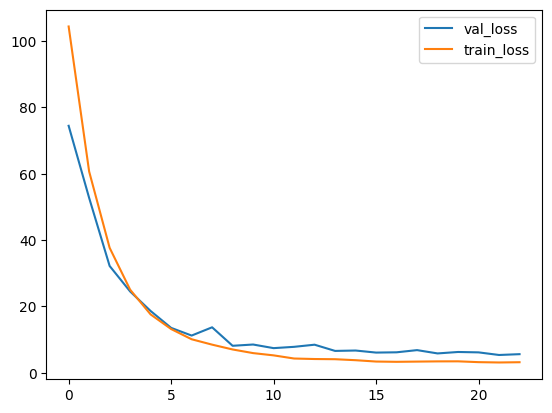

In [95]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [96]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [i for i in range(dataset.num_classes)])
torch.cuda.empty_cache() if device == 'cuda' else None

In [97]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 16.1%


<Axes: >

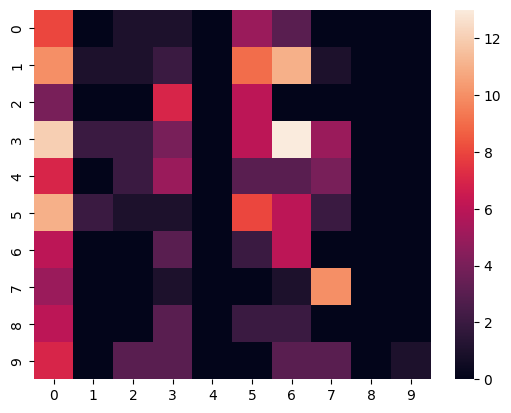

In [98]:
from seaborn import heatmap
heatmap(test_data[0])